# Data

Russell 3000 stocks, quarterly, from 2016 - 2021 was obtained from parsing through the SEC EDGAR public archives for 10-Q and 10-Q/A balance sheet, cash flow, and income statments.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

BASE_DIR = os.path.abspath(os.path.dirname('__file__'))

DATA_DIR = os.path.join(BASE_DIR, 'data')

def csv_to_df(file,directory=DATA_DIR):
    file = os.path.join(directory, f'{file}.csv')
    file = pd.read_csv(file)
    label_list = [file.loc[x][0] for x in file.index]
    file = pd.DataFrame.transpose(file)
    file.columns = label_list
    file = file.drop(['Unnamed: 0'])
    file.reset_index()
    return file

In [2]:
ticker_list = [x[:x.find('.')] for x in sorted(os.listdir(DATA_DIR)) if x.endswith('csv')]
dfx = {i : csv_to_df(i) for i in ticker_list}
quarter_list = list(dfx[ticker_list[0]].keys())
time_range = quarter_list[:-4]

# Piotroski F-Score


In [3]:
def keyerrorwrap(func):
    def wrapper(*args,**kwargs):
        try: return func(*args,**kwargs)
        except KeyError:return False
    def swapper(*args,**kwargs):return func(*args,**kwargs)
    return wrapper

def lastQ(q):
    try: return quarter_list[quarter_list.index(q) + 1]
    except IndexError:return False

In [4]:
class Score: #class methods for calculating score subcomponents
    def __init__(self,ticker):
        self.ticker = ticker
    #Piotroski Score
    #Profitability Criteria
    @keyerrorwrap 
    def pos_NI(self,quarter): # Positive NI
        return self.ticker.loc['netincome'][quarter] >0        

    @keyerrorwrap
    def pos_ROA(self,quarter): # Positive ROA
        return  (self.ticker.loc['netincome'][quarter]/self.ticker.loc['totalassets'][quarter] > 1)
        
    @keyerrorwrap
    def pos_OCF(self,quarter):# Positive Operating CF
        return self.ticker.loc['operatingincome'][quarter] >0
        
    @keyerrorwrap
    def CF_NI(self,quarter): #operating cashflow is greater than net incom
        return  (self.ticker.loc['operatingincome'][quarter] > self.ticker.loc['netincome'][quarter])

    # Leverage, Liquidity, and Source of Funds Criteria
    @keyerrorwrap 
    def low_LT_debt(self,quarter):
        cur_q = self.ticker[quarter]
        pre_q = self.ticker[lastQ(quarter)]
        return (cur_q.loc['longtermdebt'] / cur_q.loc['totalliab']) > (pre_q.loc['longtermdebt'] / pre_q.loc['totalliab'])
        
    @keyerrorwrap
    def current_ratio(self,quarter): #greater than previous
        cur_q = self.ticker[quarter]
        pre_q = self.ticker[lastQ(quarter)]
        return (cur_q.loc['totalassets'] / cur_q.loc['totalliab']) > (pre_q.loc['totalassets'] / pre_q.loc['totalliab'])

    @keyerrorwrap
    def new_shares(self,quarter): #no new shares issued
        return self.ticker.loc['commonstock'][quarter] != self.ticker.loc['commonstock'][lastQ(quarter)]

    #Operating Efficiency Criteria
    @keyerrorwrap 
    def gross_margin(self,quarter):  # greater gross margin in current quarter compared to last quarter        
        cur_q = self.ticker[quarter]
        pre_q = self.ticker[lastQ(quarter)]
        return (cur_q.loc['operatingincome'] - cur_q.loc['costofrevenue']) > (pre_q.loc['operatingincome'] - pre_q.loc['costofrevenue'])

    @keyerrorwrap
    def asset_turnover(self,quarter): # greater asset turnover in current quarter compared to last quarter         
        cur_q = self.ticker[quarter]
        pre_q = self.ticker[lastQ(quarter)]
        return (cur_q.loc['costofrevenue'] / cur_q.loc['totalassets']) > (pre_q.loc['costofrevenue'] / pre_q.loc['totalassets'])

    #consolidated criteria classic f-score
    def f_score(self, quarter):
        f_score = 0
        f_score_funcs =[self.asset_turnover,
                        self.gross_margin,
                        self.new_shares,
                        self.current_ratio,
                        self.low_LT_debt,
                        self.CF_NI,
                        self.pos_OCF,
                        self.pos_ROA,
                        self.pos_NI]
        for criteria in f_score_funcs:
            f_score += criteria(quarter)
        return f_score

In [5]:
#dataframe for price by stock and quarter
price_df =  pd.DataFrame({x: dfx[x].loc['price'] for x in ticker_list if 'price' in dfx[x].index}, index=quarter_list)

#dataframe for f-score by stock and quarter
df_fscore = pd.DataFrame({x: {Quart: Score(dfx[x]).f_score(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

In [6]:
df_fscore.describe()

,AAPL,AAT,AAWW,ABBV,ABC,ABCB,ABG,ABMD,ABR,ABT,...,WAB,WABC,WAFD,WASH,WAT,WBS,WCC,WD,WDAY,WDC
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.750000,3.625000,3.750000,3.625000,2.916667,2.958333,3.083333,3.416667,3.416667,3.416667,...,1.625000,1.333333,1.333333,3.041667,3.125000,3.041667,3.166667,3.208333,2.958333,3.041667
std,0.442326,0.710939,0.442326,0.710939,1.017955,1.122078,1.059806,0.583592,0.775532,0.775532,...,1.013496,0.481543,0.481543,0.858673,0.797414,0.806450,0.761387,0.779028,0.806450,0.750604
min,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,3.750000,3.000000,3.750000,3.000000,2.000000,2.000000,2.750000,3.000000,3.000000,3.000000,...,1.000000,1.000000,1.000000,2.750000,2.750000,2.000000,3.000000,3.000000,2.000000,2.750000
50%,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,...,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,2.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,2.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


# Sharpe Ratios

In [7]:
def calculate_sharpe_ratio(portfolio = None, data = price_df):
    risk_free_rate = -0.0626
    try: dat_len=len(data.columns)
    except AttributeError: dat_len=len(data)
    if portfolio is None: portfolio=[1.0/dat_len]*dat_len
    log_return = np.sum(np.log(data/data.shift())*portfolio, axis=1)
    sharpe_ratio = (log_return.mean() - risk_free_rate) /log_return.std() 
    return sharpe_ratio

def give_weight(selected_stocks=[]):    #portfolio weight is evenly distributed among selected symbols 
    if len(selected_stocks) ==0:portfolio=[1.0/len(ticker_list)]*len(ticker_list)
    else:
        portfolio = [0]*len(ticker_list)
        weight = 1.0/len(selected_stocks)
        for stock in selected_stocks:
            portfolio[ticker_list.index(stock)] = weight
    return portfolio

log_return = lambda portfolio =[] : np.sum(np.log(price_df/price_df.shift())*give_weight(portfolio), axis=1)

In [8]:
#the mean f-scores of individual symbols over 2016-2021 
fscore_means = {x : df_fscore[x].mean() for x in ticker_list}

#log returns of individual stocks 
df_log_r = {x : calculate_sharpe_ratio( give_weight([x])) for x in ticker_list}

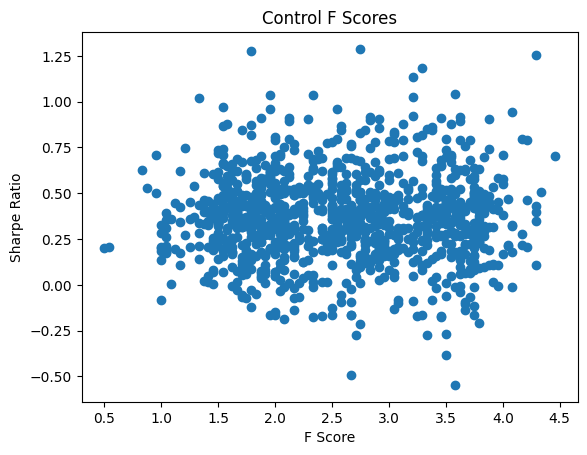

In [9]:
plt.ylabel("Sharpe Ratio")
plt.xlabel("F Score")
plt.title('Control F Scores')
X = np.array([*fscore_means.values()])
Y = np.array([*df_log_r.values()])
plt.scatter(X,Y)
plt.show()

<Axes: >

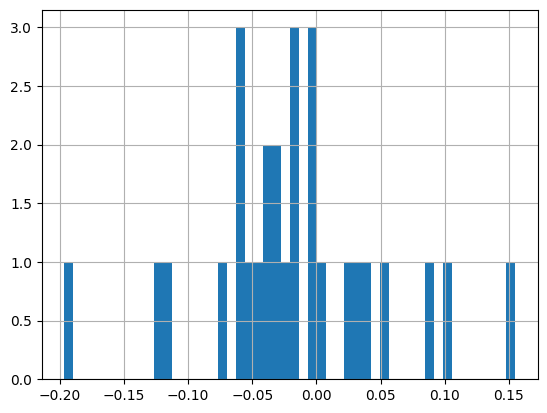

In [10]:
Returns = log_return()

fig, ax = plt.subplots()

Returns.hist(bins=50, ax=ax)

# Alterations

## Gross Profibility instead of Net

In [11]:
# Positive gross profit
@keyerrorwrap 
def pos_GP(self,quarter): 
    return self.ticker.loc['grossprofit'][quarter] >0

Score.pos_GP = pos_GP

def gross_profit(self, quarter):
    score = 0
    score_funcs =[self.asset_turnover,
                    self.gross_margin,
                    self.new_shares,
                    self.current_ratio,
                    self.low_LT_debt,
                    self.CF_NI,
                    self.pos_OCF,
                    self.pos_ROA,
                    self.pos_GP] # only change from prev model
    for criteria in score_funcs:
        score += criteria(quarter)
    return score

Score.gross_profit = gross_profit

In [12]:
df_grossP = pd.DataFrame({x: {Quart: Score(dfx[x]).gross_profit(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

In [13]:
df_grossP.describe()

,AAPL,AAT,AAWW,ABBV,ABC,ABCB,ABG,ABMD,ABR,ABT,...,WAB,WABC,WAFD,WASH,WAT,WBS,WCC,WD,WDAY,WDC
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.0,24.000000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,3.750000,3.625000,3.750000,3.625000,3.000000,3.041667,3.166667,3.000000,3.000000,3.000000,...,1.375000,1.0,0.958333,3.416667,3.500000,3.37500,3.583333,3.583333,3.416667,3.541667
std,0.442326,0.710939,0.442326,0.710939,0.932505,1.041703,0.963087,0.589768,0.780189,0.780189,...,1.013496,0.0,0.204124,0.717282,0.589768,0.76967,0.503610,0.503610,0.583592,0.508977
min,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.0,0.000000,1.000000,2.000000,1.00000,3.000000,3.000000,2.000000,3.000000
25%,3.750000,3.000000,3.750000,3.000000,2.750000,2.750000,3.000000,3.000000,3.000000,3.000000,...,1.000000,1.0,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,1.000000,1.0,1.000000,3.500000,4.000000,3.50000,4.000000,4.000000,3.000000,4.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.250000,3.250000,...,1.000000,1.0,1.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,1.0,1.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000


## Return on Equity

In [14]:
@keyerrorwrap
def pos_RoE(self,quarter): # greater RoE in current quarter compared to last quarter         
    cur_q = self.ticker[quarter]
    pre_q = self.ticker[lastQ(quarter)]
    return (cur_q.loc['netincome'] / cur_q.loc['totalstockholderequity']) > (pre_q.loc['netincome'] / pre_q.loc['totalstockholderequity'])


Score.pos_RoE = pos_RoE

def RoE_included(self, quarter):
    score = 0
    score_funcs =[self.asset_turnover,
                    self.gross_margin,
                    self.new_shares,
                    self.current_ratio,
                    self.low_LT_debt,
                    self.CF_NI,
                    self.pos_OCF,
                    self.pos_RoE,
                    self.pos_ROA,
                    self.pos_NI]
    for criteria in score_funcs:
        score += criteria(quarter)
    return score

Score.RoE_included = RoE_included


In [15]:
df_RoE = pd.DataFrame({x: {Quart: Score(dfx[x]).RoE_included(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

## Removal of Net Income Factors

In [16]:
def no_NI_factors(self, quarter):
    score = 0
    score_funcs =[self.asset_turnover,
                    self.gross_margin,
                    self.new_shares,
                    self.current_ratio,
                    self.low_LT_debt,
                    self.pos_OCF]
    for criteria in score_funcs:
        score += criteria(quarter)
    return score

Score.no_NI_factors = no_NI_factors

In [17]:
df_noNI = pd.DataFrame({x: {Quart: Score(dfx[x]).no_NI_factors(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

## Gross Profit with no Net Income Factors 

In [18]:
def GP_NI(self, quarter):
    score = 0
    score_funcs =[self.asset_turnover,
                    self.gross_margin,
                    self.new_shares,
                    self.current_ratio,
                    self.low_LT_debt,
                    self.pos_OCF,
                    self.pos_GP]
    for criteria in score_funcs:
        score += criteria(quarter)
    return score

Score.GP_NI = GP_NI

In [19]:
df_GPNI = pd.DataFrame({x: {Quart: Score(dfx[x]).GP_NI(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

## Gross Profit and RoE with out Net Income Factors 

In [20]:
def GP_ROE_NI(self, quarter):
    score = 0
    score_funcs =[self.asset_turnover,
                    self.gross_margin,
                    self.new_shares,
                    self.current_ratio,
                    self.low_LT_debt,
                    self.pos_OCF,
                    self.pos_GP]
    for criteria in score_funcs:
        score += criteria(quarter)
    return score

Score.GP_ROE_NI = GP_ROE_NI

In [21]:
df_GPROEIN = pd.DataFrame({x: {Quart: Score(dfx[x]).GP_ROE_NI(Quart) for Quart in time_range} for x in ticker_list}, index=time_range)

# Portfolios of Different Scoring Methods

In [22]:
select_top_half = lambda condition: [x  for x in condition if (condition[x].mean() > condition.mean().mean())]

select_top_Q   = lambda condition: [x  for x in condition if (condition[x].mean() > condition.mean().quantile(.75))]

select_Q2_3   = lambda condition: [x  for x in condition if (condition[x].mean() > condition.mean().quantile(.5) and condition[x].mean() < condition.mean().quantile(.75))]

select_Q1_2   = lambda condition: [x  for x in condition if (condition[x].mean() > condition.mean().quantile(.25) and condition[x].mean() < condition.mean().quantile(.5))]

select_low_Q   = lambda condition: [x  for x in condition if (condition[x].mean() < condition.mean().quantile(.25))]

select_top1std = lambda condition: [x  for x in condition if (condition[x].mean() > (condition.mean().mean() + condition.std().mean()))]

select_low1std = lambda condition: [x  for x in condition if (condition[x].mean() < (condition.mean().mean() + condition.std().mean()))]

high_p_tickers = lambda condition: [x for x in ticker_list if ((calculate_sharpe_ratio( give_weight([x]))>0) and (condition[x].mean() > (condition.mean().mean() + condition.std().mean())))]


In [23]:
portfolio_criteria = {'F Score' : df_fscore,
                    'Gross Profit' : df_grossP,
                    'RoE included' : df_RoE,
                    'NI excluded' : df_noNI,
                    'GP NI' : df_GPNI,
                    'GP ROE NI' : df_GPROEIN}

select_funcs = {#' top half':select_top_half,
                ' > Q3'   : select_top_Q,
                ' Q2-3'   : select_Q2_3,
                ' Q1-2'   : select_Q1_2,
                ' < Q1'   : select_low_Q,
                #' > 1 std':select_top1std ,
                #' < 1 std':select_low1std,
                }

portfolios = {}
for i in portfolio_criteria:
    for x in select_funcs:
        portfolios[f'{i}{x}'] = select_funcs[x](portfolio_criteria[i])


In [24]:
portfolio_scores = {'Control' : calculate_sharpe_ratio()}
for port in portfolios:
    portfolio_scores[port]= calculate_sharpe_ratio(give_weight(portfolios[port]))

portfolio_scores = pd.Series(portfolio_scores)

In [25]:
portfolio_scores

Control              0.620596
F Score > Q3         0.628904
F Score Q2-3         0.623090
F Score Q1-2         0.628323
F Score < Q1         0.592017
Gross Profit > Q3    0.627620
Gross Profit Q2-3    0.599757
Gross Profit Q1-2    0.620163
Gross Profit < Q1    0.602298
RoE included > Q3    0.626999
RoE included Q2-3    0.649863
RoE included Q1-2    0.593291
RoE included < Q1    0.603298
NI excluded > Q3     0.619266
NI excluded Q2-3     0.609112
NI excluded Q1-2     0.657871
NI excluded < Q1     0.575377
GP NI > Q3           0.614189
GP NI Q2-3           0.612395
GP NI Q1-2           0.599543
GP NI < Q1           0.627407
GP ROE NI > Q3       0.614189
GP ROE NI Q2-3       0.612395
GP ROE NI Q1-2       0.599543
GP ROE NI < Q1       0.627407
dtype: float64

<Axes: title={'center': 'Portfolio Sharpe Ratios'}, ylabel='Sharpe Ratio'>

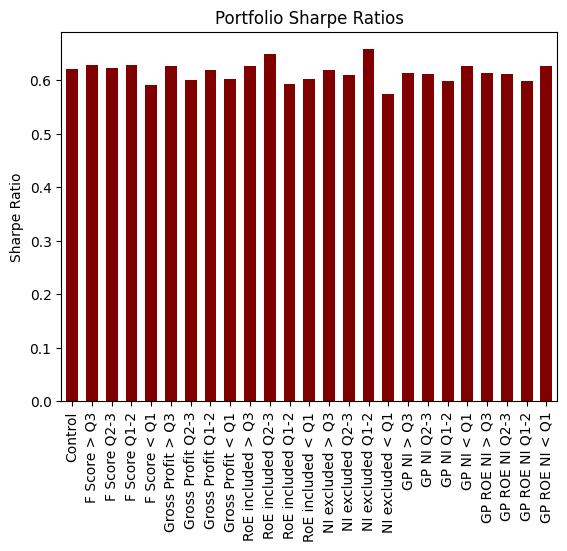

In [26]:
plt.ylabel("Sharpe Ratio")
plt.title("Portfolio Sharpe Ratios")


portfolio_scores.plot.bar(color ='maroon',width = 0.6)


In [27]:
# selecting by high sharpe and high 'score'
high_sharpe = {}
for i in portfolio_criteria:high_sharpe[i] = calculate_sharpe_ratio(give_weight(high_p_tickers(portfolio_criteria[i])))

<Axes: title={'center': 'Modified Scores of High Sharpe Portfolios'}, ylabel='Portfolio Sharpe Ratios'>

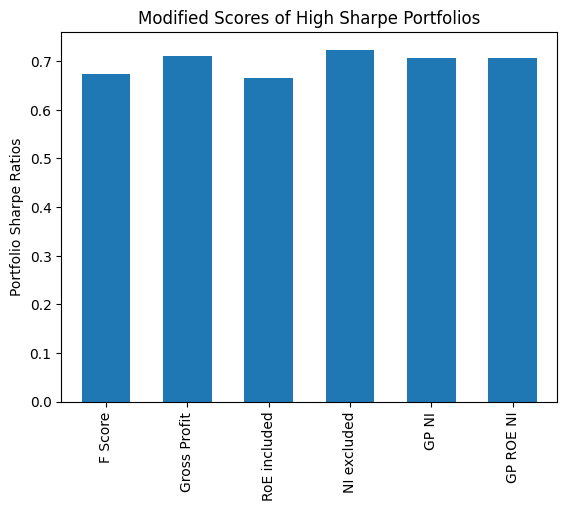

In [28]:
high_sharpe = pd.Series(high_sharpe)


plt.ylabel("Portfolio Sharpe Ratios")
plt.title("Modified Scores of High Sharpe Portfolios")


high_sharpe.plot.bar(width = 0.6)


In [29]:
high_sharpe

F Score         0.673979
Gross Profit    0.709649
RoE included    0.664460
NI excluded     0.723820
GP NI           0.707034
GP ROE NI       0.707034
dtype: float64